## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import string
fields = ['title', 'selftext', 'flair']

df = pd.read_csv('reddit_with_flairs.csv', skipinitialspace=True, usecols=fields)

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback


In [3]:
df=df.fillna(" ")
df.shape

(205363, 3)

In [4]:
df = df[df['title'].str.split().str.len().lt(55)]
df.shape

(205142, 3)

In [5]:
df = df[df['selftext'].str.split().str.len().lt(400)]
df.shape

(203541, 3)

## Cleaning

In [6]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)



In [7]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [8]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [9]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [10]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all, can't")

'You all, cannot'

## Joining selftext and title

In [11]:
df["text"] = df["title"] +" "+ df["selftext"]
df.shape

(203541, 4)

In [12]:
df['text']=df['text'].apply(lambda x : expand_contractions(x))
df['text']=df['text'].apply(lambda x : remove_URL(x))
df['text']=df['text'].apply(lambda x : remove_punct(x))
df['text']=df['text'].apply(lambda x : remove_html(x))
df['text']=df['text'].apply(lambda x : remove_emoji(x))


In [13]:
df.text

0         Crocodile in water tiger on land Humans Gays a...
1         Samsung Galaxy S9 Will launch Next Month At MW...
2         Exposed Kerala madrasas teaching Wahabism Saud...
3         How can we start a small service provider firm...
4         Fsociety Aadhaar  To generate the password the...
5                            Should I drop out of college  
6         Samsung Galaxy A8 2018 Launched in India for R...
7         ASKRandia doctors Is there a metric or a sign ...
8         Post Bhima Koregaon Violence Police Target Dal...
9         The Marriage Algorithm Indias CasteConscious A...
10        Cervical cancer vaccine that RSS wing wanted o...
11        Saw an ad of escort which provides a tamil act...
12        India I need your help When I was in Sweden I ...
13        Whar are some Good magazines you subscribed to   
14        Soon pay for each and every banking transactio...
15        Are People Without Aadhaar NonExistent for Gov...
16        India  should it focus on Serv

In [14]:
from sklearn import model_selection
df_n, df_test = model_selection.train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df.flair.values
    )


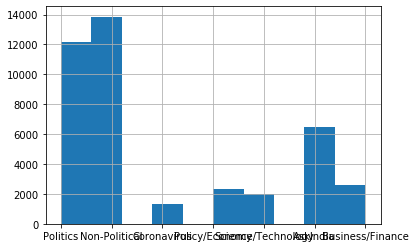

In [15]:
df_test.flair.hist()

In [16]:
df_n.flair.describe()


count            162832
unique                7
top       Non-Political
freq              55420
Name: flair, dtype: object

In [17]:
df_n.to_csv('reddit_model_train_valid.csv', index=False)
df_test.to_csv('reddit_model_test.csv', index=False)

## Code for BERT this will be implemented later in Kaggle because of lack of compute

In [19]:
TRAINING_FILE = "reddit_model_train_valid.csv"

In [ ]:
import transformers


MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 10
BERT_PATH = "./bert_uncased/"
MODEL_PATH = "app/model.bin"
TRAINING_FILE = "reddit_model_train_valid.csv"
TOKENIZER = transformers.BertTokenizer.from_pretrained(
    BERT_PATH,
    do_lower_case=True
)

In [23]:
import pandas as pd
dfx = pd.read_csv(TRAINING_FILE).fillna("none")
dfx.flair.unique()

array(['Coronavirus', 'Politics', 'Non-Political', 'AskIndia',
       'Policy/Economy', 'Science/Technology', 'Business/Finance'],
      dtype=object)

# Code for LSTM without pretrained embeddings

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

Using TensorFlow backend.


In [4]:
MAX_NB_WORDS = 50000

MAX_SEQUENCE_LENGTH = 512
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(dfx['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 180763 unique tokens.


In [5]:
X = tokenizer.texts_to_sequences(dfx['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (162832, 512)


In [6]:

Y = pd.get_dummies(dfx['flair']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (162832, 7)


In [7]:

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(146548, 512) (146548, 7)
(16284, 512) (16284, 7)


In [8]:

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 512, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 512, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 5,081,107
Trainable params: 5,081,107
Non-trainable params: 0
_________________________________________________________________
None


In [9]:

epochs = 10
batch_size = 256

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

Train on 117238 samples, validate on 29310 samples
Epoch 1/10
117238/117238 [==============================] - 714s 6ms/step - loss: 1.2518 - acc: 0.5493 - val_loss: 1.0478 - val_acc: 0.6309
Epoch 2/10
117238/117238 [==============================] - 650s 6ms/step - loss: 0.9191 - acc: 0.6767 - val_loss: 0.9731 - val_acc: 0.6531
Epoch 3/10
117238/117238 [==============================] - 656s 6ms/step - loss: 0.7932 - acc: 0.7212 - val_loss: 1.0033 - val_acc: 0.6442
Epoch 4/10
117238/117238 [==============================] - 659s 6ms/step - loss: 0.7070 - acc: 0.7493 - val_loss: 1.0261 - val_acc: 0.6478


In [10]:
Y = pd.get_dummies(dfx['flair'])
Y.head(10)

,AskIndia,Business/Finance,Coronavirus,Non-Political,Policy/Economy,Politics,Science/Technology
0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0
5,0,0,0,0,0,1,0
6,0,0,0,0,1,0,0
7,0,0,0,0,0,1,0
8,0,0,0,0,0,1,0
9,0,0,0,0,0,1,0


In [19]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

16284/16284 [==============================] - 45s 3ms/step
Test set
  Loss: 1.002
  Accuracy: 0.656


In [20]:
print(accr)

[1.002420417215923, 0.6556742815325987]


In [33]:
jj=model.predict(X_test)
jj=np.argmax(jj,axis=1)

Y_true=np.argmax(Y_test,axis=1)

(16284,)


# Classification Report on Test Dataset

In [34]:
from sklearn.metrics import classification_report

target_names = ['AskIndia', 'Business/Finance', 'Coronavirus','Non-Political', 'Policy/Economy', 'Politics', 'Science/Technology']
print(classification_report(Y_true, jj, target_names=target_names))

                    precision    recall  f1-score   support

          AskIndia       0.60      0.63      0.61      2567
  Business/Finance       0.64      0.57      0.61      1030
       Coronavirus       0.66      0.58      0.62       544
     Non-Political       0.65      0.66      0.66      5529
    Policy/Economy       0.49      0.41      0.45       907
          Politics       0.73      0.78      0.76      4912
Science/Technology       0.56      0.32      0.41       795

          accuracy                           0.66     16284
         macro avg       0.62      0.57      0.59     16284
      weighted avg       0.65      0.66      0.65     16284



In [13]:
import matplotlib.pyplot as plt

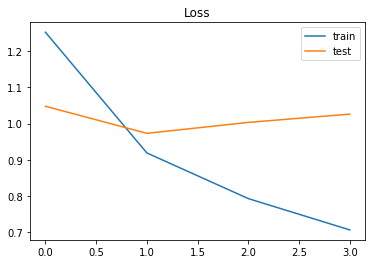

In [14]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

## Save Model and weights

In [15]:
# serialize model to JSON
model_json = model.to_json()
with open("lstm_no_glove.json", "w") as json_file:
	json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("lstm_no_glove.h5")
print("Saved model to disk")


Saved model to disk


# Prediction Example

In [18]:
import numpy as np
new_complaint = ['BJP wants us to see Indian Sonia Gandhi as Italian but Canadian Akshay Kumar as Indian']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['AskIndia', 'Business/Finance', 'Coronavirus','Non-Political', 'Policy/Economy', 'Politics', 'Science/Technology']
print(pred, labels[np.argmax(pred)])

[[7.7152285e-03 1.7205245e-04 1.0427540e-04 2.2130255e-02 1.1592682e-03
  9.6858370e-01 1.3516496e-04]] Politics


# Code for LSTM with pretrained embeddings

In [25]:
MAX_NB_WORDS = 50000

MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(dfx['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 151548 unique tokens.


In [27]:
import numpy as np
import os
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 400000 word vectors.


In [28]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NB_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
  if i < MAX_NB_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector



# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)



Filling pre-trained embeddings...


In [29]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))

In [30]:

model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 500, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 5,081,107
Trainable params: 81,107
Non-trainable params: 5,000,000
_________________________________________________________________
None


In [31]:
X = tokenizer.texts_to_sequences(dfx['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (162832, 500)


In [32]:

Y = pd.get_dummies(dfx['flair']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (162832, 7)


In [33]:

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(146548, 500) (146548, 7)
(16284, 500) (16284, 7)


In [37]:

epochs = 20
batch_size = 512

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

Train on 117238 samples, validate on 29310 samples
Epoch 1/20
117238/117238 [==============================] - 495s 4ms/step - loss: 1.0380 - acc: 0.6157 - val_loss: 1.0097 - val_acc: 0.6263
Epoch 2/20
117238/117238 [==============================] - 497s 4ms/step - loss: 1.0314 - acc: 0.6187 - val_loss: 1.0049 - val_acc: 0.6299
Epoch 3/20
117238/117238 [==============================] - 495s 4ms/step - loss: 1.0245 - acc: 0.6208 - val_loss: 0.9997 - val_acc: 0.6308
Epoch 4/20
117238/117238 [==============================] - 494s 4ms/step - loss: 1.0207 - acc: 0.6225 - val_loss: 0.9998 - val_acc: 0.6311
Epoch 5/20
117238/117238 [==============================] - 495s 4ms/step - loss: 1.0166 - acc: 0.6256 - val_loss: 0.9936 - val_acc: 0.6342
Epoch 6/20
117238/117238 [==============================] - 495s 4ms/step - loss: 1.0119 - acc: 0.6253 - val_loss: 0.9940 - val_acc: 0.6334
Epoch 7/20
117238/117238 [==============================] - 495s 4ms/step - loss: 1.0073 - acc: 0.6281 - val_

In [38]:
# serialize model to JSON
model_json = model.to_json()
with open("lstm_glove.json", "w") as json_file:
	json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("lstm_glove.h5")
print("Saved model to disk")


Saved model to disk


In [39]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

16284/16284 [==============================] - 29s 2ms/step
Test set
  Loss: 0.969
  Accuracy: 0.646


In [41]:
jj=model.predict(X_test)
jj=np.argmax(jj,axis=1)

Y_true=np.argmax(Y_test,axis=1)
from sklearn.metrics import classification_report

target_names = ['AskIndia', 'Business/Finance', 'Coronavirus','Non-Political', 'Policy/Economy', 'Politics', 'Science/Technology']
print(classification_report(Y_true, jj, target_names=target_names))

                    precision    recall  f1-score   support

          AskIndia       0.61      0.63      0.62      2567
  Business/Finance       0.62      0.58      0.60      1030
       Coronavirus       0.63      0.49      0.55       544
     Non-Political       0.62      0.69      0.65      5529
    Policy/Economy       0.52      0.33      0.41       907
          Politics       0.74      0.75      0.74      4912
Science/Technology       0.50      0.34      0.40       795

          accuracy                           0.65     16284
         macro avg       0.61      0.54      0.57     16284
      weighted avg       0.64      0.65      0.64     16284



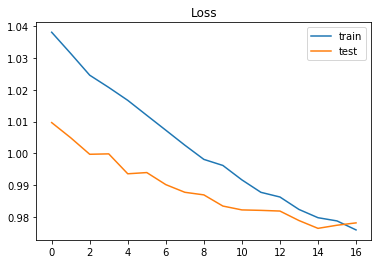

In [42]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

## LSTM on only titles (w/o pretrained word embeddings)

In [46]:
dfx['title']=dfx['title'].apply(lambda x : expand_contractions(x))
dfx['title']=dfx['title'].apply(lambda x : remove_URL(x))
dfx['title']=dfx['title'].apply(lambda x : remove_punct(x))
dfx['title']=dfx['title'].apply(lambda x : remove_html(x))
dfx['title']=dfx['title'].apply(lambda x : remove_emoji(x))

In [47]:
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 400
# This is fixed.
EMBEDDING_DIM = 50

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(dfx['title'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88142 unique tokens.


In [48]:
X = tokenizer.texts_to_sequences(dfx['title'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (162832, 400)


In [49]:

Y = pd.get_dummies(dfx['flair']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (162832, 7)


In [50]:

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(146548, 400) (146548, 7)
(16284, 400) (16284, 7)


In [51]:

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 50)           2500000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 400, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 707       
Total params: 2,561,107
Trainable params: 2,561,107
Non-trainable params: 0
_________________________________________________________________
None


In [52]:

epochs = 20
batch_size = 256

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

Train on 117238 samples, validate on 29310 samples
Epoch 1/20
117238/117238 [==============================] - 421s 4ms/step - loss: 1.3086 - acc: 0.5170 - val_loss: 1.1136 - val_acc: 0.6028
Epoch 2/20
117238/117238 [==============================] - 421s 4ms/step - loss: 0.9748 - acc: 0.6562 - val_loss: 1.0048 - val_acc: 0.6422
Epoch 3/20
117238/117238 [==============================] - 420s 4ms/step - loss: 0.8368 - acc: 0.7046 - val_loss: 0.9954 - val_acc: 0.6459
Epoch 4/20
117238/117238 [==============================] - 427s 4ms/step - loss: 0.7526 - acc: 0.7333 - val_loss: 1.0320 - val_acc: 0.6394
Epoch 5/20
117238/117238 [==============================] - 428s 4ms/step - loss: 0.6919 - acc: 0.7544 - val_loss: 1.0533 - val_acc: 0.6349


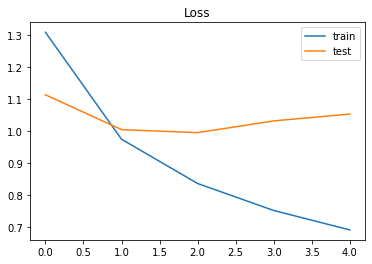

In [53]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [54]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

16284/16284 [==============================] - 21s 1ms/step
Test set
  Loss: 1.036
  Accuracy: 0.642


In [55]:
jj=model.predict(X_test)
jj=np.argmax(jj,axis=1)

Y_true=np.argmax(Y_test,axis=1)
from sklearn.metrics import classification_report

target_names = ['AskIndia', 'Business/Finance', 'Coronavirus','Non-Political', 'Policy/Economy', 'Politics', 'Science/Technology']
print(classification_report(Y_true, jj, target_names=target_names))

                    precision    recall  f1-score   support

          AskIndia       0.56      0.58      0.57      2567
  Business/Finance       0.65      0.57      0.61      1030
       Coronavirus       0.63      0.62      0.62       544
     Non-Political       0.65      0.62      0.64      5529
    Policy/Economy       0.51      0.41      0.45       907
          Politics       0.71      0.80      0.75      4912
Science/Technology       0.47      0.42      0.44       795

          accuracy                           0.64     16284
         macro avg       0.60      0.57      0.58     16284
      weighted avg       0.64      0.64      0.64     16284



In [56]:
# serialize model to JSON
model_json = model.to_json()
with open("lstm_no_glove_title.json", "w") as json_file:
	json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("lstm_no_glove_title.h5")
print("Saved model to disk")


Saved model to disk


## Code for BERT finetuning (code is complete just need to train the model, we can see in the output that my GPU was insufficient for training)

In [10]:

import torch


class BERTDataset:
    def __init__(self, text, flair):
        self.text = text
        self.flair = flair
        self.tokenizer = TOKENIZER
        self.max_len = MAX_LEN
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item):
        text = str(self.text[item])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.flair[item], dtype=torch.long)
        }

In [11]:
import torch.nn as nn
from tqdm import tqdm


def loss_fn(outputs, targets):
    return nn.CrossEntropyLoss()(outputs, targets.view(-1, 1))


def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()

    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets = d["targets"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )

        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()


def eval_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            targets = d["targets"]

            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.long)

            outputs = model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids
            )
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [12]:

import transformers
import torch.nn as nn


class BERTBaseUncased(nn.Module):
    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(BERT_PATH)
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, 7)
    
    def forward(self, ids, mask, token_type_ids):
        _, o2 = self.bert(
            ids, 
            attention_mask=mask,
            token_type_ids=token_type_ids
        )
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output

In [13]:
import pandas as pd
dfx = pd.read_csv(TRAINING_FILE).fillna("none")
dfx.flair.unique()

array(['Coronavirus', 'Politics', 'Non-Political', 'AskIndia',
       'Policy/Economy', 'Science/Technology', 'Business/Finance'],
      dtype=object)

In [14]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
dfx['flair'] = le.fit_transform(dfx.flair.values)
print(le.classes_)

['AskIndia' 'Business/Finance' 'Coronavirus' 'Non-Political'
 'Policy/Economy' 'Politics' 'Science/Technology']


In [19]:

import torch
import pandas as pd
import torch.nn as nn
import numpy as np


from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

def run():
    df_train, df_valid = model_selection.train_test_split(
        dfx,
        test_size=0.1,
        random_state=42,
        stratify=dfx.flair.values
    )

    df_train = df_train.reset_index(drop=True)
    df_valid = df_valid.reset_index(drop=True)

    train_dataset = BERTDataset(
        text=df_train.text.values,
        flair=df_train.flair.values
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=4
    )

    valid_dataset = BERTDataset(
        text=df_valid.text.values,
        flair=df_valid.flair.values
    )

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=1
    )

    device = torch.device("cpu")
    model = BERTBaseUncased()
    torch.cuda.empty_cache()  # entirely clear all allocated memory

    model.to(device)
    
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

    num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
    optimizer = AdamW(optimizer_parameters, lr=3e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    model = nn.DataParallel(model)

    best_accuracy = 0
    for epoch in range(EPOCHS):
        train_fn(train_data_loader, model, optimizer, device, scheduler)
        outputs, targets = eval_fn(valid_data_loader, model, device)
        outputs = np.array(outputs) >= 0.5
        accuracy = metrics.accuracy_score(targets, outputs)
        print(f"Accuracy Score = {accuracy}")
        if accuracy > best_accuracy:
            torch.save(model.state_dict(), MODEL_PATH)
            best_accuracy = accuracy


if __name__ == "__main__":
    run()

RuntimeError: CUDA out of memory. Tried to allocate 90.00 MiB (GPU 0; 3.81 GiB total capacity; 2.56 GiB already allocated; 65.75 MiB free; 2.60 GiB reserved in total by PyTorch)